This notebook is for snapping of substations to lines

In [27]:
import os
import matplotlib.pyplot as plt 
import geopandas as gpd
import geoplot
import pandas as pd
import numpy as np

# Africa shape data

In [28]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
africa = world.query('continent == "Africa"')
nigeriaplot = world.query('name == "Nigeria"')
#world

# Power data

In [29]:
pathg = os.path.realpath("data")+'/africa_all_generators.geojson'
paths = os.path.realpath("data")+'/africa_all_substations.geojson'
pathl = os.path.realpath("data")+'/africa_all_lines.geojson'

generators = gpd.read_file(pathg).set_crs(epsg=4326, inplace=True)
points = gpd.read_file(paths).set_crs(epsg=4326, inplace=True)
lines = gpd.read_file(pathl).set_crs(epsg=4326, inplace=True)

In [30]:
points

,tags.power,tags.substation,tags.voltage,Country,tags.frequency,id,Type,geometry
0,substation,yes,None,algeria,None,593521765.0,Way,POINT (2.59801 36.57077)
1,substation,transmission,220000;66000,algeria,50,217970970.0,Way,POINT (5.71208 34.87673)
2,substation,None,None,algeria,None,381266479.0,Way,POINT (-0.52571 35.73821)
3,substation,None,None,algeria,None,381720324.0,Way,POINT (1.30349 35.32594)
4,substation,transmission,220000;66000,algeria,50,317645796.0,Way,POINT (6.78075 33.30697)
...,...,...,...,...,...,...,...,...
2247,substation,None,None,zimbabwe,None,284408391.0,Way,POINT (29.81438 -18.92636)
2248,substation,transmission,88000,zimbabwe,None,194257366.0,Way,POINT (26.47382 -18.38033)
2249,substation,None,None,zimbabwe,None,467421248.0,Way,POINT (29.98553 -22.23683)
2250,substation,None,None,zimbabwe,None,685274681.0,Way,POINT (30.06992 -20.32912)


In [31]:
points.bounds

,minx,miny,maxx,maxy
0,2.598011,36.570768,2.598011,36.570768
1,5.712083,34.876727,5.712083,34.876727
2,-0.525707,35.738207,-0.525707,35.738207
3,1.303490,35.325943,1.303490,35.325943
4,6.780753,33.306974,6.780753,33.306974
...,...,...,...,...
2247,29.814376,-18.926360,29.814376,-18.926360
2248,26.473825,-18.380332,26.473825,-18.380332
2249,29.985527,-22.236829,29.985527,-22.236829
2250,30.069923,-20.329117,30.069923,-20.329117


In [32]:
offset = 0.001
bbox = points.bounds + [-offset, -offset, offset, offset]

In [33]:
bbox

,minx,miny,maxx,maxy
0,2.597011,36.569768,2.599011,36.571768
1,5.711083,34.875727,5.713083,34.877727
2,-0.526707,35.737207,-0.524707,35.739207
3,1.302490,35.324943,1.304490,35.326943
4,6.779753,33.305974,6.781753,33.307974
...,...,...,...,...
2247,29.813376,-18.927360,29.815376,-18.925360
2248,26.472825,-18.381332,26.474825,-18.379332
2249,29.984527,-22.237829,29.986527,-22.235829
2250,30.068923,-20.330117,30.070923,-20.328117


In [34]:
lines

,tags.power,tags.circuits,tags.voltage,Country,tags.frequency,id,Type,tags.cables,geometry
0,line,None,220000,algeria,None,217933340,Way,3,"LINESTRING (6.02132 31.76176, 6.02420 31.81913..."
1,line,None,None,algeria,None,379084622,Way,None,"LINESTRING (3.98331 36.73061, 3.98419 36.72171..."
2,line,None,220000,algeria,None,217930451,Way,3,"LINESTRING (6.05928 31.78705, 6.05336 31.77971..."
3,line,None,220000,algeria,None,226923216,Way,3,"LINESTRING (-0.04353 28.42990, -0.05001 28.45194)"
4,line,None,60000,algeria,None,382497408,Way,3,"LINESTRING (3.14027 36.59825, 3.11152 36.65977..."
...,...,...,...,...,...,...,...,...,...
21349,line,None,None,zimbabwe,None,490949513,Way,None,"LINESTRING (31.74113 -16.93072, 31.76445 -16.8..."
21350,line,None,132000,zimbabwe,50,240033786,Way,3,"LINESTRING (30.94045 -17.78308, 30.93996 -17.7..."
21351,line,None,330000,zimbabwe,None,179121072,Way,3,"LINESTRING (28.75848 -16.51714, 28.76329 -16.5..."
21352,line,None,330000,zimbabwe,None,740677131,Way,1,"LINESTRING (28.50503 -20.23918, 28.50480 -20.2..."


In [35]:
hits = bbox.apply(lambda row: list(lines.sindex.intersection(row)), axis=1)

In [36]:
display(hits)

0                          [732, 281, 801, 65, 453, 1285]
1       [1183, 1891, 765, 901, 758, 1607, 1067, 373, 8...
2                                                   [196]
3                            [204, 1242, 448, 1070, 1750]
4                    [685, 872, 133, 152, 819, 1318, 697]
                              ...                        
2247                         [21072, 21081, 21315, 21165]
2248                         [21104, 21177, 21116, 21254]
2249                   [9789, 17043, 21151, 15859, 17335]
2250                                [21113, 21198, 21143]
2251    [21253, 21268, 21119, 21271, 21245, 21197, 21301]
Length: 2252, dtype: object

In [37]:
tmp = pd.DataFrame({
    # index of points table
    "pt_idx": np.repeat(hits.index, hits.apply(len)),
    # ordinal position of line - access via iloc later
    "line_i": np.concatenate(hits.values)
})

In [38]:
tmp

,pt_idx,line_i
0,0,732.0
1,0,281.0
2,0,801.0
3,0,65.0
4,0,453.0
...,...,...
12263,2251,21119.0
12264,2251,21271.0
12265,2251,21245.0
12266,2251,21197.0


In [39]:
tmp = tmp.join(lines.reset_index(drop=True), on="line_i")

tmp = tmp.join(points.geometry.rename("point"), on="pt_idx")

tmp = gpd.GeoDataFrame(tmp, geometry="geometry", crs=points.crs)

In [40]:
tmp

,pt_idx,line_i,tags.power,tags.circuits,tags.voltage,Country,tags.frequency,id,Type,tags.cables,geometry,point
0,0,732.0,line,None,400000,algeria,None,382460531,Way,3,"LINESTRING (2.07928 36.57461, 2.08052 36.56581...",POINT (2.59801 36.57077)
1,0,281.0,line,None,400000,algeria,None,382460532,Way,3,"LINESTRING (2.07982 36.57460, 2.08413 36.56471...",POINT (2.59801 36.57077)
2,0,801.0,line,None,220000,algeria,None,382460572,Way,3,"LINESTRING (2.58768 36.50225, 2.71415 36.56336...",POINT (2.59801 36.57077)
3,0,65.0,line,None,220000,algeria,None,382460576,Way,3,"LINESTRING (2.58768 36.50225, 2.59548 36.49991...",POINT (2.59801 36.57077)
4,0,453.0,line,None,220000,algeria,None,382460578,Way,6,"LINESTRING (2.57137 36.50721, 2.63168 36.54789...",POINT (2.59801 36.57077)
...,...,...,...,...,...,...,...,...,...,...,...,...
12263,2251,21119.0,line,None,132000,zimbabwe,50,665698745,Way,3,"LINESTRING (29.78075 -18.75587, 29.79813 -18.7...",POINT (29.78268 -18.65514)
12264,2251,21271.0,line,None,132000,zimbabwe,50,665698746,Way,3,"LINESTRING (29.78301 -18.65507, 29.84010 -18.6...",POINT (29.78268 -18.65514)
12265,2251,21245.0,line,1,132000,zimbabwe,50,499642671,Way,3,"LINESTRING (29.89808 -18.32284, 29.83006 -18.3...",POINT (29.78268 -18.65514)
12266,2251,21197.0,line,1,132000,zimbabwe,50,499642674,Way,3,"LINESTRING (29.78005 -18.75603, 29.78346 -18.7...",POINT (29.78268 -18.65514)


In [41]:
tmp["snap_dist"] = tmp.geometry.distance(gpd.GeoSeries(tmp.point))

ipykernel_launcher:1: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



In [42]:
tmp

,pt_idx,line_i,tags.power,tags.circuits,tags.voltage,Country,tags.frequency,id,Type,tags.cables,geometry,point,snap_dist
0,0,732.0,line,None,400000,algeria,None,382460531,Way,3,"LINESTRING (2.07928 36.57461, 2.08052 36.56581...",POINT (2.59801 36.57077),0.084490
1,0,281.0,line,None,400000,algeria,None,382460532,Way,3,"LINESTRING (2.07982 36.57460, 2.08413 36.56471...",POINT (2.59801 36.57077),0.083225
2,0,801.0,line,None,220000,algeria,None,382460572,Way,3,"LINESTRING (2.58768 36.50225, 2.71415 36.56336...",POINT (2.59801 36.57077),0.057199
3,0,65.0,line,None,220000,algeria,None,382460576,Way,3,"LINESTRING (2.58768 36.50225, 2.59548 36.49991...",POINT (2.59801 36.57077),0.063226
4,0,453.0,line,None,220000,algeria,None,382460578,Way,6,"LINESTRING (2.57137 36.50721, 2.63168 36.54789...",POINT (2.59801 36.57077),0.037792
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12263,2251,21119.0,line,None,132000,zimbabwe,50,665698745,Way,3,"LINESTRING (29.78075 -18.75587, 29.79813 -18.7...",POINT (29.78268 -18.65514),0.001589
12264,2251,21271.0,line,None,132000,zimbabwe,50,665698746,Way,3,"LINESTRING (29.78301 -18.65507, 29.84010 -18.6...",POINT (29.78268 -18.65514),0.000343
12265,2251,21245.0,line,1,132000,zimbabwe,50,499642671,Way,3,"LINESTRING (29.89808 -18.32284, 29.83006 -18.3...",POINT (29.78268 -18.65514),0.000338
12266,2251,21197.0,line,1,132000,zimbabwe,50,499642674,Way,3,"LINESTRING (29.78005 -18.75603, 29.78346 -18.7...",POINT (29.78268 -18.65514),0.009290


In [43]:
tolerance = offset
# Discard any lines that are greater than tolerance from points
tmp = tmp.loc[tmp.snap_dist <= tolerance]
# Sort on ascending snap distance, so that closest goes to top
tmp = tmp.sort_values(by=["snap_dist"])



In [52]:
# group by the index of the points and take the first, which is the
# closest line 
closest = tmp.groupby("pt_idx").first()
# construct a GeoDataFrame of the closest lines
closest = gpd.GeoDataFrame(closest, geometry="geometry")

In [53]:
closest

,line_i,tags.power,tags.circuits,tags.voltage,Country,tags.frequency,id,Type,tags.cables,geometry,point,snap_dist
pt_idx,,,,,,,,,,,,
1,1556.0,line,1,220000,algeria,None,218514369,Way,3,"LINESTRING (4.48211 35.70698, 4.48777 35.72404...",POINT (5.71208 34.87673),0.000347
2,196.0,line,None,60000,algeria,None,381266462,Way,6,"LINESTRING (-0.47714 35.72105, -0.50226 35.722...",POINT (-0.52571 35.73821),0.000934
3,1070.0,line,None,60000,algeria,None,381720328,Way,6,"LINESTRING (1.30389 35.32612, 1.31206 35.33698)",POINT (1.30349 35.32594),0.000439
4,1318.0,line,1,220000,algeria,None,520151125,Way,3,"LINESTRING (6.98265 34.50599, 6.98166 34.51144...",POINT (6.78075 33.30697),0.000898
5,1016.0,line,None,60000,algeria,None,382460579,Way,3,"LINESTRING (2.62913 36.47636, 2.69763 36.49425...",POINT (2.62910 36.47595),0.000413
...,...,...,...,...,...,...,...,...,...,...,...,...
2246,21213.0,line,None,132000,zimbabwe,50,651546009,Way,3,"LINESTRING (31.37613 -17.31027, 31.37891 -17.3...",POINT (31.29607 -17.33029),0.000628
2248,21254.0,line,1,88000,zimbabwe,50,194257358,Way,3,"LINESTRING (26.47399 -18.38047, 26.48063 -18.3...",POINT (26.47382 -18.38033),0.000219
2249,21151.0,line,1,132000,zimbabwe,50,739103087,Way,3,"LINESTRING (30.03641 -22.33940, 30.01609 -22.3...",POINT (29.98553 -22.23683),0.000259


In [54]:
# Position of nearest point from start of the line
pos = closest.geometry.project(gpd.GeoSeries(closest.point))
# Get new point location geometry
new_pts = closest.geometry.interpolate(pos)

In [55]:
pos

pt_idx
1       1.634701
2       0.052760
3       0.000000
4       1.940953
5       0.000000
          ...   
2246    0.113663
2248    0.000000
2249    0.129991
2250    0.019093
2251    0.365959
Length: 1704, dtype: float64

In [47]:
#Identify the columns we want to copy from the closest line to the point, such as a line ID.
line_columns = 'line_i'
# Create a new GeoDataFrame from the columns from the closest line and new point geometries (which will be called "geometries")
snapped = gpd.GeoDataFrame(
closest[line_columns],geometry=new_pts)

# Join back to the original points:
updated_points = points.drop(columns=["geometry"]).join(snapped)
# You may want to drop any that didn't snap, if so:
updated_points = updated_points.dropna(subset=["geometry"])

In [48]:
updated_points.to_file('./updates_points.geojson', driver="GeoJSON")  # Generate GeoJson

# Map

<AxesSubplot:>

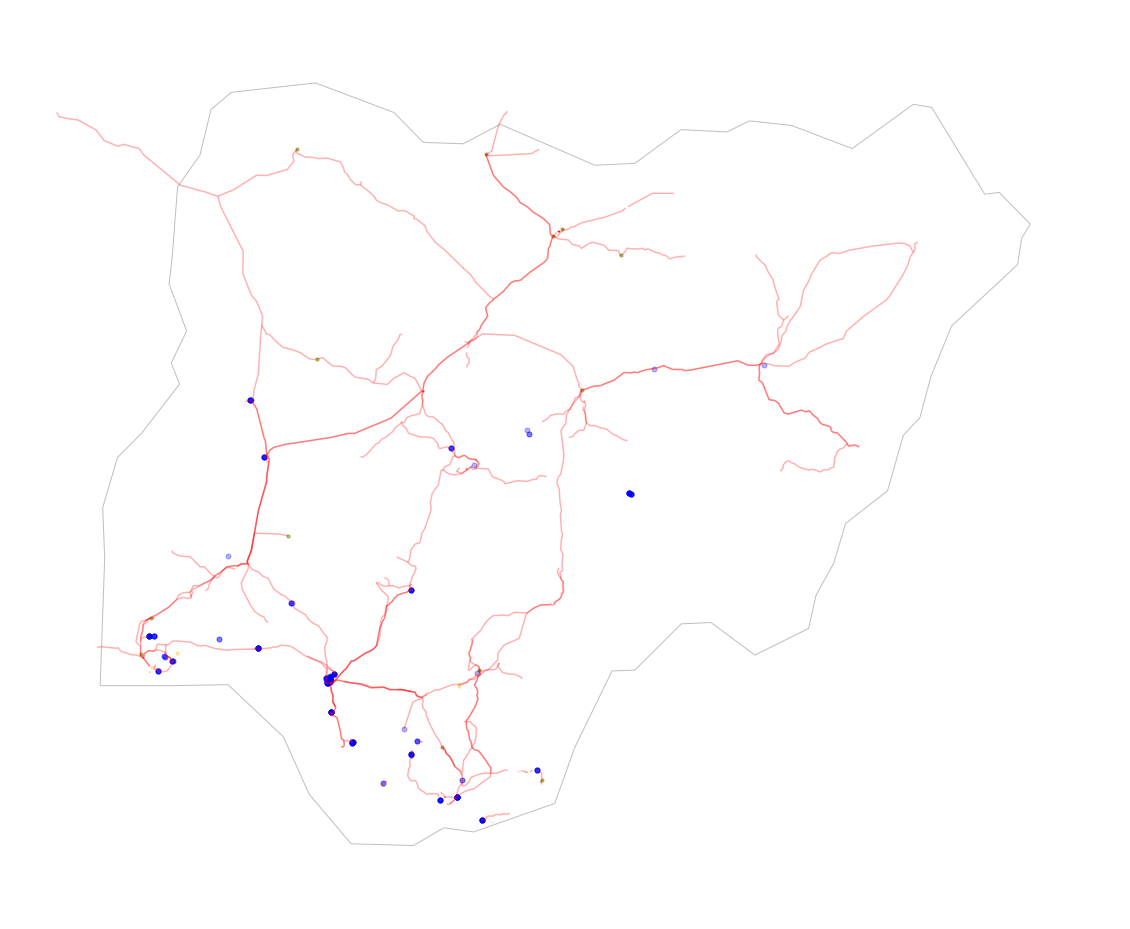

In [49]:
ax = geoplot.polyplot(nigeriaplot ,edgecolor='grey', alpha = 0.5, figsize=(20, 20))

points.loc[points['Country'] == 'nigeria'].plot(figsize=(20, 20),markersize=10, color='orange',alpha = 0.3, ax=ax)
updated_points.loc[updated_points['Country'] == 'nigeria'].plot(figsize=(20, 20),markersize=10, color='green',alpha = 0.3, ax=ax)
generators.loc[generators['Country'] == 'nigeria'].plot(figsize=(20, 20),markersize=25, color='blue',alpha = 0.3, ax=ax)
lines.loc[lines['Country'] == 'nigeria'].plot(figsize=(20, 20),markersize=25, color='red',alpha = 0.3, ax=ax)


#plt.savefig('africa_transmission_and substations_110.png')

In [50]:
import pandas as pd
import hvplot.pandas

df = pd.read_csv(
    "https://raw.githubusercontent.com/FRESNA/powerplantmatching/master/matched_data_red.csv",
    index_col=0
)

df.hvplot.points(
    'lon',
    'lat',
    geo=True,
    frame_height=750,
    c='Fueltype',
    size=df["Capacity"] / 5,
    alpha=0.4,
    tiles='CartoLight',
    hover_cols=['Name', 'Fueltype', "Technology", 'YearCommissioned', "Retrofit", "Capacity"],
    xlim=(-12,32),
).opts(
    active_tools=['pan', 'wheel_zoom']
)

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [lon,lat]   (Fueltype,_size,Name,Technology,YearCommissioned,Retrofit,Capacity)

In [51]:
substation_df = pd.read_csv(
    "./data/africa_all_substations.csv",
    index_col=0
)

substation_df.hvplot.points(
    'lon',
    'lat',
    geo=True,
    frame_height=750,
    c='Fueltype',
    size=df["Capacity"] / 5,
    alpha=0.4,
    tiles='CartoLight',
    hover_cols=['Name', 'Fueltype', "Technology", 'YearCommissioned', "Retrofit", "Capacity"],
    xlim=(-12,32),
).opts(
    active_tools=['pan', 'wheel_zoom']
)

DataError: Supplied data does not contain specified dimensions, the following dimensions were not found: ['lon', 'lat']

PandasInterface expects tabular data, for more information on supported datatypes see http://holoviews.org/user_guide/Tabular_Datasets.html